<a href="https://colab.research.google.com/github/Muhire-taa/Forex-makert-trading-advisory-and-forecasting/blob/main/merged_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install TA-Lib


In [ ]:
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=e9fcd3b78c73f72326cfadaaabab07df9c83d80a5601feba72aa3ea75b036123
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [ ]:
!pip install numpy==1.23.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 68.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


In [ ]:
import  ta
#import talib
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GRU, LSTM, Bidirectional,Dropout
from keras import regularizers
from keras.regularizers import l1_l2
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Load the data for all timeframes
df_daily = pd.read_csv("/content/drive/MyDrive/output_D1.csv")
df_4h = pd.read_csv("/content/drive/MyDrive/output_4H.csv")
df_1h = pd.read_csv("/content/drive/MyDrive/output_H1.csv")
df_30min = pd.read_csv("/content/drive/MyDrive/output_30M.csv")


In [ ]:
# Create fibonaci retracements levels and indicators for all timeframes
def create_indicators(df, window_slow=24, window_fast=18, window_signal=12):
    ema = ta.trend.EMAIndicator(close=df['close'], window=18, fillna=False)
    df['EMA'] = ema.ema_indicator()
    df["rsi"] = ta.momentum.RSIIndicator(df["close"], window=18).rsi()
    df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=18).average_true_range()
    bb = ta.volatility.BollingerBands(df['close'], window=24)
    df['upper_bb'] = bb.bollinger_hband()
    df['lower_bb'] = bb.bollinger_lband()
    # Calculate the Stochastic Oscillator using ta library
    stoch = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=18)
    # Add %K and %D to dataframe
    df['%K'] = stoch.stoch()
    df['%D'] = stoch.stoch_signal()
    # macd
    ema_slow = df['close'].ewm(span=window_slow).mean()
    ema_fast = df['close'].ewm(span=window_fast).mean()

    # Calculate the MACD line
    macd_line = ema_fast - ema_slow

    # Calculate the signal line (EMA of MACD line)
    signal_line = macd_line.ewm(span=window_signal).mean()

    # Calculate the histogram
    histogram = macd_line - signal_line

    # Add the MACD indicators to the DataFrame
    df['macd_line'] = macd_line
    df['signal_line'] = signal_line
    df['histogram'] = histogram
    # Define breakout signals
    df['breakout_above_upper'] = np.where(df['close'] > df['upper_bb'], 1, -1)
    df['breakout_below_lower'] = np.where(df['close'] < df['lower_bb'], -1, 1)
    # Calculate the rolling high, low, and diff values for the past 18 candles
    high = df['high'].rolling(window=48).max()
    low = df['low'].rolling(window=48).min()
    diff = high - low

    # Calculate the Fibonacci retracement levels for the rolling window
    fib_levels = [high - (x / 100) * diff for x in [23.6, 38.2, 50, 61.8, 76.4]]

    # Add the Fibonacci retracement levels to the dataframe
    df['fib_23.6'] = fib_levels[0]
    df['fib_38.2'] = fib_levels[1]
    df['fib_50'] = fib_levels[2]
    df['fib_61.8'] = fib_levels[3]
    df['fib_76.4'] = fib_levels[4]
    # add special candlestick patterns for price reversals
    #candles for downtrend reversals
    # df['CDLHAMMER'] = talib.CDLHAMMER(df['open'], df['high'], df['low'], df['close'])
    # df['CDLMORNINGSTAR'] = talib.CDLMORNINGSTAR(df['open'], df['high'], df['low'], df['close'])
    # df['CDLENGULFING'] = talib.CDLENGULFING(df['open'], df['high'], df['low'], df['close'])
    # df['CDLPIERCING'] = talib.CDLPIERCING(df['open'], df['high'], df['low'], df['close'])
    # df['CDLINVERTEDHAMMER'] = talib.CDLINVERTEDHAMMER(df['open'], df['high'], df['low'], df['close'])
    # #candles for uptrend reversals
    # df['CDLSHOOTINGSTAR'] = talib.CDLSHOOTINGSTAR(df['open'], df['high'], df['low'], df['close'])
    # df['CDLHANGINGMAN'] = talib.CDLHANGINGMAN(df['open'], df['high'], df['low'], df['close'])
    # df['CDLEVENINGSTAR'] = talib.CDLEVENINGSTAR(df['open'], df['high'], df['low'], df['close'])
    # df['CDLDARKCLOUDCOVER'] = talib.CDLDARKCLOUDCOVER(df['open'], df['high'], df['low'], df['close'])
    # Compute the rolling maximum and minimum prices
    window_size =48
    df['supply_zone'] = df['high'].rolling(window_size).max()
    df['demand_zone'] = df['low'].rolling(window_size).min()

    return df

In [ ]:
daily_df = create_indicators(df_daily)
fourh_df = create_indicators(df_4h)
oneh_df = create_indicators(df_1h)
thirtymin_df = create_indicators(df_30min)

In [ ]:
# Combine all dataframes into one
df = pd.concat([daily_df, fourh_df, oneh_df,thirtymin_df], axis=0)



In [ ]:
# Drop any rows with NaN values
df.dropna(inplace=True)
df

,time,open,high,low,close,tick_volume,spread,real_volume,EMA,rsi,...,histogram,breakout_above_upper,breakout_below_lower,fib_23.6,fib_38.2,fib_50,fib_61.8,fib_76.4,supply_zone,demand_zone
47,1971-06-03,0.55430,0.55430,0.55430,0.55430,1,50,0,0.550833,61.701966,...,-0.000136,-1,1,0.553432,0.550234,0.54765,0.545066,0.541868,0.55860,0.53670
48,1971-06-04,0.55450,0.55450,0.55450,0.55450,1,50,0,0.551219,61.977801,...,-0.000109,-1,1,0.553432,0.550234,0.54765,0.545066,0.541868,0.55860,0.53670
49,1971-06-07,0.55540,0.55540,0.55540,0.55540,1,50,0,0.551659,63.239315,...,-0.000075,-1,1,0.553432,0.550234,0.54765,0.545066,0.541868,0.55860,0.53670
50,1971-06-08,0.55590,0.55590,0.55590,0.55590,1,50,0,0.552105,63.943027,...,-0.000046,-1,1,0.553432,0.550234,0.54765,0.545066,0.541868,0.55860,0.53670
51,1971-06-09,0.55710,0.55710,0.55710,0.55710,1,50,0,0.552631,65.615684,...,-0.000008,-1,1,0.553432,0.550234,0.54765,0.545066,0.541868,0.55860,0.53670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68048,2023-03-24 04:30:00,1.08241,1.08254,1.08199,1.08206,1527,0,0,1.083749,33.943472,...,-0.000076,-1,1,1.090394,1.088788,1.08749,1.086192,1.084586,1.09299,1.08199
68049,2023-03-24 05:00:00,1.08206,1.08241,1.08173,1.08233,892,0,0,1.083600,35.890381,...,-0.000058,-1,1,1.090333,1.088689,1.08736,1.086031,1.084387,1.09299,1.08173
68050,2023-03-24 05:30:00,1.08234,1.08287,1.08233,1.08287,1152,0,0,1.083523,39.656663,...,-0.000028,-1,1,1.090333,1.088689,1.08736,1.086031,1.084387,1.09299,1.08173
68051,2023-03-24 06:00:00,1.08287,1.08304,1.08232,1.08277,1131,0,0,1.083444,39.205055,...,-0.000006,-1,1,1.090333,1.088689,1.08736,1.086031,1.084387,1.09299,1.08173


In [ ]:
df.set_axis(df['time'], inplace=True)
df.drop(columns=['time','open','real_volume','tick_volume','spread'], inplace=True)
df

<ipython-input-12-80da2defc79d>:1: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(df['time'], inplace=True)


,high,low,close,EMA,rsi,atr,upper_bb,lower_bb,%K,%D,...,histogram,breakout_above_upper,breakout_below_lower,fib_23.6,fib_38.2,fib_50,fib_61.8,fib_76.4,supply_zone,demand_zone
time,,,,,,,,,,,,,,,,,,,,,
1971-06-03,0.55430,0.55430,0.55430,0.550833,61.701966,0.001635,0.560674,0.539260,60.185185,34.837963,...,-0.000136,-1,1,0.553432,0.550234,0.54765,0.545066,0.541868,0.55860,0.53670
1971-06-04,0.55450,0.55450,0.55450,0.551219,61.977801,0.001555,0.560331,0.540944,62.037037,50.308642,...,-0.000109,-1,1,0.553432,0.550234,0.54765,0.545066,0.541868,0.55860,0.53670
1971-06-07,0.55540,0.55540,0.55540,0.551659,63.239315,0.001519,0.559780,0.542903,70.370370,64.197531,...,-0.000075,-1,1,0.553432,0.550234,0.54765,0.545066,0.541868,0.55860,0.53670
1971-06-08,0.55590,0.55590,0.55590,0.552105,63.943027,0.001462,0.558840,0.545277,75.000000,69.135802,...,-0.000046,-1,1,0.553432,0.550234,0.54765,0.545066,0.541868,0.55860,0.53670
1971-06-09,0.55710,0.55710,0.55710,0.552631,65.615684,0.001448,0.559155,0.545845,86.111111,77.160494,...,-0.000008,-1,1,0.553432,0.550234,0.54765,0.545066,0.541868,0.55860,0.53670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-24 04:30:00,1.08254,1.08199,1.08206,1.083749,33.943472,0.001126,1.089736,1.079659,1.230228,4.690518,...,-0.000076,-1,1,1.090394,1.088788,1.08749,1.086192,1.084586,1.09299,1.08199
2023-03-24 05:00:00,1.08241,1.08173,1.08233,1.083600,35.890381,0.001102,1.088904,1.079825,11.811024,6.630189,...,-0.000058,-1,1,1.090333,1.088689,1.08736,1.086031,1.084387,1.09299,1.08173
2023-03-24 05:30:00,1.08287,1.08233,1.08287,1.083523,39.656663,0.001070,1.088249,1.079970,31.578947,14.873400,...,-0.000028,-1,1,1.090333,1.088689,1.08736,1.086031,1.084387,1.09299,1.08173


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
sc_Y = MinMaxScaler()
scaled_data = sc.fit_transform(df)
sc_Y.fit(df['close'].values.reshape(-1,1))

MinMaxScaler()

In [ ]:
scaled_data = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)
scaled_data.head()

,high,low,close,EMA,rsi,atr,upper_bb,lower_bb,%K,%D,...,histogram,breakout_above_upper,breakout_below_lower,fib_23.6,fib_38.2,fib_50,fib_61.8,fib_76.4,supply_zone,demand_zone
time,,,,,,,,,,,,,,,,,,,,,
1971-06-03,0.000000,0.000000,0.000000,0.000000,0.625110,0.045803,0.001724,0.000000,0.601852,0.348380,...,0.375679,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1971-06-04,0.000191,0.000192,0.000191,0.000371,0.628415,0.043141,0.001402,0.001615,0.620370,0.503086,...,0.377701,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1971-06-07,0.001048,0.001055,0.001052,0.000793,0.643528,0.041925,0.000884,0.003493,0.703704,0.641975,...,0.380187,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1971-06-08,0.001525,0.001534,0.001531,0.001222,0.651959,0.040035,0.000000,0.005769,0.750000,0.691358,...,0.382309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1971-06-09,0.002668,0.002685,0.002678,0.001727,0.671998,0.039549,0.000297,0.006314,0.861111,0.771605,...,0.385184,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
N_past =18
M_future =1

In [ ]:
test_percentage = 0.15
test_split = int(len(scaled_data)*(1 - test_percentage))

In [ ]:
train = scaled_data[:test_split]
test = scaled_data[test_split-N_past:]
print(train.shape)
print(test.shape)

(164945, 22)
(29127, 22)


In [ ]:
def split_dataset_X_Y(data,past,future,jump=1):
    X,Y=[],[]
    for i in range(0,len(data)-past-future+1,jump):
        X.append(df[i:(i+past)].values)
        Y.append(df['close'][(i+past):(i+past+future)])
    return np.array(X),np.array(Y)

In [ ]:
X_train, y_train = split_dataset_X_Y(train, N_past, M_future)
X_test, y_test = split_dataset_X_Y(test, N_past, M_future)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [ ]:
EPOCHS = 100
model = Sequential()
model.add(LSTM(32, input_shape=(N_past, df.shape[1]),activation='tanh', kernel_initializer='glorot_uniform',kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001), bias_regularizer=l1_l2(l1=0.0001, l2=0.0001),return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(32,activation='tanh', kernel_initializer='glorot_uniform',kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001), bias_regularizer=l1_l2(l1=0.0001, l2=0.0001),return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(LSTM(128,activation='tanh', kernel_initializer='glorot_uniform',kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001), bias_regularizer=l1_l2(l1=0.0001, l2=0.0001),return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128,activation='tanh', kernel_initializer='glorot_uniform',kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001), bias_regularizer=l1_l2(l1=0.0001, l2=0.0001),return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(M_future))
#build the model
model.build(input_shape=(None, N_past, df.shape[1]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 18, 32)            7040      
                                                                 
 batch_normalization_4 (Batc  (None, 18, 32)           128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 18, 32)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 18, 64)           16640     
 nal)                                                            
                                                                 
 batch_normalization_5 (Batc  (None, 18, 64)           256       
 hNormalization)                                                 
                                                      

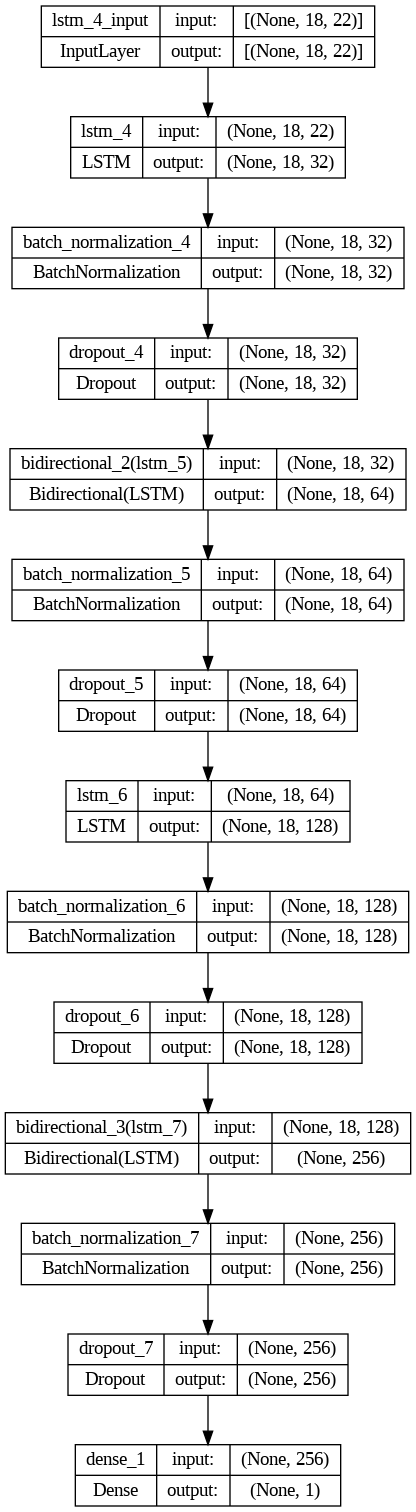

In [ ]:
# Plot the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [ ]:
# Compile the model
model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [ ]:
# Set up early stopping to prevent overfitting
early_stop =EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(f'finalyear2.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_validation, y_validation), shuffle=False, batch_size=16, verbose=2,callbacks=[early_stop,checkpoint])

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.60007, saving model to finalyear2.h5
8762/8762 - 145s - loss: 1.2287 - mse: 0.3255 - mae: 0.4083 - rmse: 0.5705 - val_loss: 0.6001 - val_mse: 0.0078 - val_mae: 0.0705 - val_rmse: 0.0883 - 145s/epoch - 17ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.60007 to 0.04598, saving model to finalyear2.h5
8762/8762 - 131s - loss: 0.2450 - mse: 0.0188 - mae: 0.1033 - rmse: 0.1371 - val_loss: 0.0460 - val_mse: 0.0017 - val_mae: 0.0314 - val_rmse: 0.0417 - 131s/epoch - 15ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.04598 to 0.00327, saving model to finalyear2.h5
8762/8762 - 133s - loss: 0.0156 - mse: 0.0030 - mae: 0.0426 - rmse: 0.0545 - val_loss: 0.0033 - val_mse: 5.8940e-04 - val_mae: 0.0180 - val_rmse: 0.0243 - 133s/epoch - 15ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.00327 to 0.00140, saving model to finalyear2.h5
8762/8762 - 130s - loss: 0.0038 - mse: 0.0022 - mae: 0.0370 - rmse: 0.0468 - val_loss: 0.0014 - va

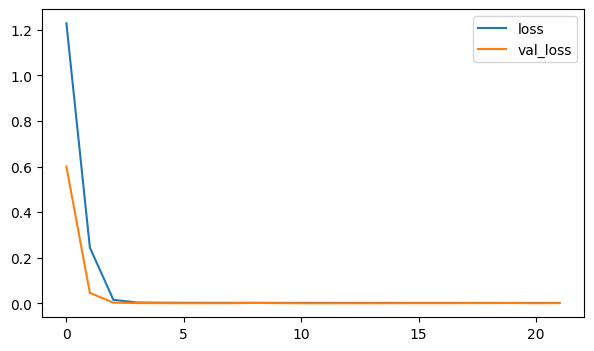

In [ ]:
plt.figure(figsize = (7,4))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

910/910 [==============================] - 7s 5ms/step


In [ ]:
new_df = pd.DataFrame({'y_test': sc_Y.inverse_transform(y_test[:,0].reshape(-1,1)).flatten(),
                   'y_pred': sc_Y.inverse_transform(y_pred[:,0].reshape(-1,1)).flatten()},
                   test[N_past:N_past+len(y_test)].index)

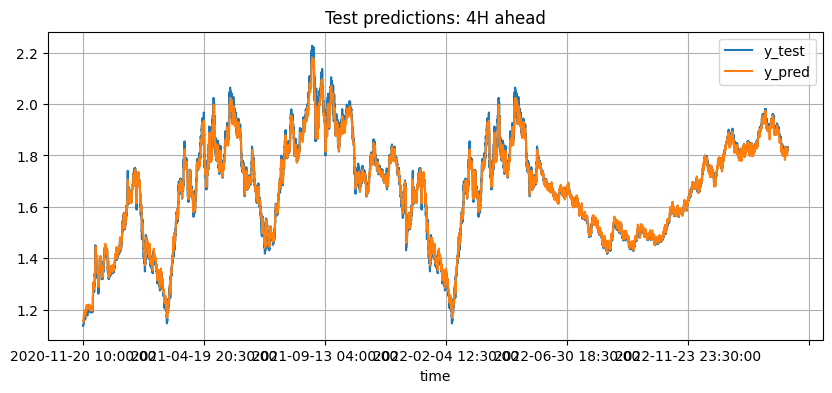

In [ ]:
fig = plt.figure(figsize=(10,4))
new_df['y_test'].plot()
new_df['y_pred'].plot()
plt.legend(loc='best')
plt.title('Test predictions: 4H ahead')
plt.grid(True)
plt.show()

In [ ]:
import sklearn.metrics as metrics
y_pred_test_lstm = model.predict(X_test)
y_train_pred_lstm = model.predict(X_train)
train_mse = metrics.mean_squared_error(y_train, y_train_pred_lstm)
rmse_train = np.sqrt(train_mse)
test_mse = metrics.mean_squared_error(y_test, y_pred_test_lstm)
rmse_test = np.sqrt(test_mse)
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_lstm)))
#print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_lstm)))
#print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

4381/4381 [==============================] - 26s 6ms/step
The  MAE on the Train set is:	0.008
The  MAE on the Test set is:	0.010


In [ ]:
100-0.011

99.989

In [ ]:
100-0.008

99.992